# Surrogate analysis for the daily mean T2 at all points

## Setting up

### Import packages here

In [1]:
import pickle
from xarray import open_dataset
from numpy import sqrt, append, isnan, datetime64, arange, linspace, zeros, sum, array, dot, stack, maximum, minimum
from sklearn.decomposition import PCA
from numpoly import ndpoly

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colorbar, colors

# some parameters
plt.rcParams.update({'font.size': 14})
#dpi = 200

In [2]:
from wrf_fvcom.variables import (
    WRF_PBL_SFCLAY, WRF_WaterZ0, WRF_MP, WRF_RA, WRF_LM,
    FVCOM_Prandtl, FVCOM_SWRadiationAbsorption,
    FVCOM_VerticalMixing, FVCOM_WindStress,
)
from wrf_fvcom.perturb import (
    transform_perturbation_matrix,
)
from surrogate.nn_regression import make_nn_surrogate_model
from surrogate.pc_regression import make_pc_surrogate_model
from surrogate.utils import surrogate_model_predict
from surrogate.gsa import compute_sensitivities, plot_sens

### Set the variables to analyze and get list of filenames

In [3]:
# time start and end 
ts = datetime64('2018-06-01')
te = datetime64('2018-09-01')

# choose variables want to analyze..
variables = [WRF_PBL_SFCLAY,
             WRF_MP, 
             WRF_RA,
             WRF_WaterZ0,
             WRF_LM,
             FVCOM_VerticalMixing,
             FVCOM_WindStress,
             FVCOM_Prandtl,
             FVCOM_SWRadiationAbsorption,
            ]

# get the variable names as a list
variable_names = [variable.name for variable in variables]

# test set does not have WRF_LM inside
variable_names_test = [variable.name for variable in variables if variable is not WRF_LM]
no_name_I = [4]
test_run_I = [0,2,4,5,8]

In [4]:
#filenames
train_parameters_file = '../output/perturbation_matrix_9variables_korobov18.nc'
test_parameters_file = '../output/perturbation_matrix_8variables_korobov19.nc'
train_output_filename = '../output/wfv_global_daily_temperature_training_set.pkl'
test_output_filename = '../output/wfv_global_daily_temperature_test_set.pkl'

## Load inputs 

In [5]:
## parameter info

# Get parameter training range and ensemble
params = open_dataset(train_parameters_file)
pnames = params.sel(variable=variable_names).variable.values
ptrain = params.sel(variable=variable_names).perturbation_matrix

# transform the input matrix
variable_matrix_train = transform_perturbation_matrix(ptrain)

In [6]:
# Get parameter test range and ensemble
params_t = open_dataset(test_parameters_file)
pnames_t = params_t.sel(variable=variable_names_test).isel(run=test_run_I).variable.values

# combining both sets of runs
ptest_t = params_t.sel(variable=variable_names_test).isel(run=test_run_I).perturbation_matrix
#
# transform into same variable number as train set and put value of 1 for Land Model
ptest = ptrain.isel(run=test_run_I)
ptest[:,[idx for idx, var_name in enumerate(variable_names) if idx not in no_name_I]] = ptest_t.values
ptest[:,no_name_I] = 1

# transform the input matrix
variable_matrix_test_t = transform_perturbation_matrix(ptest)
# transform into same scheme number as train set and put value of 0 where doesn't exist
variable_matrix_test = variable_matrix_train.isel(run=test_run_I)
scheme_names = variable_matrix_test['scheme'].values
no_scheme_I = [idx for idx, scheme_name in enumerate(scheme_names)
               if scheme_name not in variable_matrix_test_t['scheme'].values]
variable_matrix_test[:,[idx for idx, scheme_name in enumerate(scheme_names) if idx not in no_scheme_I]] = \
    variable_matrix_test_t.values
variable_matrix_test[:,no_scheme_I] = 0

In [7]:
## data info

#load the training data
with open(train_output_filename, 'rb') as fp:
    train_dict = pickle.load(fp)
    print('Done loading training data from binary file')
    
with open(test_output_filename, 'rb') as fp:
    test_dict = pickle.load(fp)
    print('Done loading test data from binary file')

Done loading training data from binary file
Done loading test data from binary file


In [8]:
# Get and check train sizes
nens = len(train_dict['runs'])
ntime = train_dict['T2'][0][0].shape[0]
ntime_, nlat, nlon = train_dict['T2'][0][1].shape
nens_ = len(train_dict['T2'])
nens__, ndim = variable_matrix_train.shape

# sanity check
assert(ntime==ntime_)
assert(nens==nens_)
assert(nens==nens__)

# Print useful info
print('Training set info:')
print(f'Ensembles size : {nens}')
print(f'Parameter dim : {ndim}')
print(f'Timeseries size : {ntime}')
print(f'Spatial size: {nlat},{nlon}')

nens_train = nens

Training set info:
Ensembles size : 18
Parameter dim : 20
Timeseries size : 111
Spatial size: 484,543


In [9]:
# Get and check train sizes
nens = len(test_dict['runs'])
ntime = test_dict['T2'][0][0].shape[0]
ntime_, nlat, nlon = test_dict['T2'][0][1].shape
nens_ = len(test_dict['T2'])
nens__, ndim = variable_matrix_test.shape

# sanity check
assert(ntime==ntime_)
assert(nens==nens_)
assert(nens==nens__)

# Print useful info
print('Test set info:')
print(f'Ensembles size : {nens}')
print(f'Parameter dim : {ndim}')
print(f'Timeseries size : {ntime}')
print(f'Spatial size: {nlat},{nlon}')

nens_test = nens

Test set info:
Ensembles size : 5
Parameter dim : 20
Timeseries size : 111
Spatial size: 484,543


In [10]:
# construct the training data into right dimensions
for rdx, run in enumerate(train_dict['T2']):
    tdx = (run[0] >= ts) & (run[0] < te)
    ntime2 = tdx.sum()
    value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
    if rdx == 0:
        trainY = value_temp
    else:
        trainY = append(trainY,value_temp,axis=0)
display(trainY.shape)
        
# construct the training data into right dimensions
for rdx, run in enumerate(test_dict['T2']):
    tdx = (run[0] >= ts) & (run[0] < te)
    ntime2_ = tdx.sum()
    value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
    if rdx == 0:
        testY = value_temp
    else:
        testY = append(testY,value_temp,axis=0)
        
display(testY.shape)

(18, 23915892)

(5, 23915892)

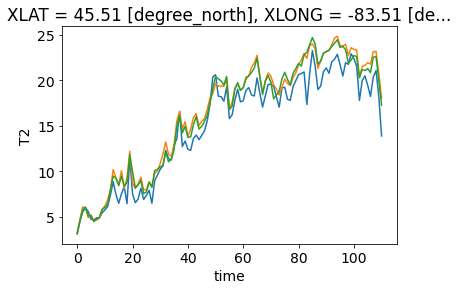

In [11]:
test_dict['T2'][0][1].isel(south_north=242,west_east=300).plot()
test_dict['T2'][-1][1].isel(south_north=242,west_east=300).plot()
train_dict['T2'][8][1].isel(south_north=242,west_east=300).plot()

##  Construct surrogate models

In [12]:
# some variables for surrogate
var_explained = 0.9 #for PCA

# using hot_enconding or not
hot_encode = True
# setup training and test inputs based on onehotencoding or not
if hot_encode:
    train_x = variable_matrix_train
    test_x = variable_matrix_test
else:
    train_x = ptrain
    test_x = ptest

# PC surrogate model parameters
polynomial_order = 2
regression_type = 'ElasticNet'

# NN surrogate model parameters
batch_size = nens_train // 3 #5 K-Fold
hidden_layers = 1
learn_rate = 0.0005
nepochs=3000

# randomization
random_seed = 222
#seed = 666 # val_loss = 0.71 , BO gives ??
#seed = 111 # val_loss = 0.67,  BO gives BO1 parameters
#seed = 99 # val_loss = 0.73 , BO gives BO1 except COARE, GOTM k-eps
#seed = 222 # val_loss = 0.66, BO gives BO1 except COARE, GOTM k-eps
#seed = None

# initialize the surrogate dictionary
kl_surrogate = dict()

### Decompose the time series

In [13]:
# Decompose the spatiotemporal series using PCA/KL
pca_obj = PCA(n_components=var_explained, random_state=random_seed, whiten=True)
pca_obj.fit(trainY)

PCA(n_components=0.9, random_state=222, whiten=True)

In [14]:
# get the outputs from the PCA
klxi_train = pca_obj.transform(trainY)
klxi_test  = pca_obj.transform(testY)
eigenratio = pca_obj.explained_variance_ratio_
print(eigenratio)
neig = pca_obj.n_components_
eigenvalues = pca_obj.explained_variance_
eigenmodes = pca_obj.components_
mean_vector = pca_obj.mean_
print(f'number of eigenmodes is {neig}')

[0.62952274 0.09183297 0.06311929 0.03860351 0.03501685 0.02507327
 0.01911373]
number of eigenmodes is 7


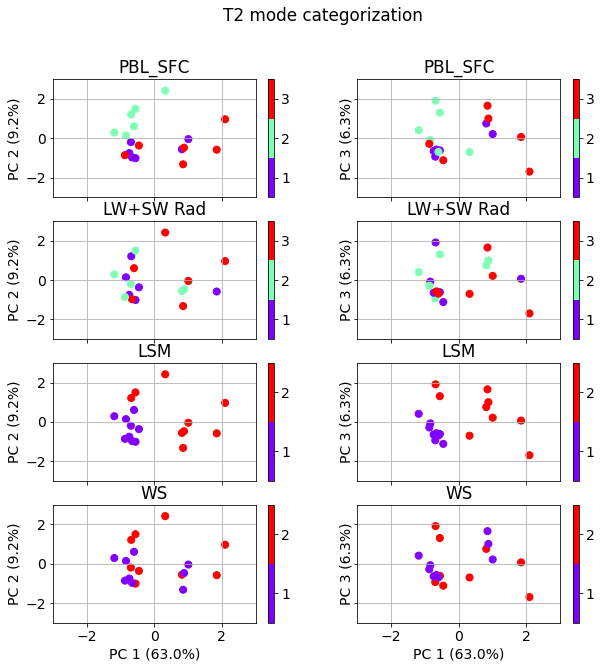

In [15]:
labels = [
    f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(eigenratio * 100)
]
important_variables = [WRF_PBL_SFCLAY, WRF_RA, WRF_LM, FVCOM_WindStress]
pname_paper = ['PBL_SFC', 'LW+SW Rad', 'LSM', 'WS']
bnds = 3

fig, axs = plt.subplots(len(important_variables), 2,sharey=True,sharex=True,figsize=(10,10))
for vv,var in enumerate(important_variables):
    cat = ptrain.sel(variable=var.name).values
    cmap = plt.cm.rainbow
    catrange = arange(cat.min()-0.5, cat.max()+1.5, 1)
    norm = colors.BoundaryNorm(catrange, cmap.N)
    for ii in [0,1]:
        py = axs[vv,ii].scatter(klxi_train[:,0],klxi_train[:,ii+1],s=50,c=cat, cmap=cmap, norm=norm)
        if vv == len(important_variables)-1:
            axs[vv,ii].set_xlabel(labels[0])
        axs[vv,ii].set_ylabel(labels[ii+1])
        axs[vv,ii].grid()
        axs[vv,ii].set_xlim([-bnds,bnds])
        axs[vv,ii].set_ylim([-bnds,bnds])
        plt.colorbar(py,ax=axs[vv,ii],ticks=catrange+0.5)
        axs[vv,ii].set_title(pname_paper[vv])
plt.suptitle('T2 mode categorization')
plt.show()

### Train and check the PC model

In [16]:
# Polynomial Chaos
from sklearn.model_selection import KFold
kl_surrogate['PC'] = make_pc_surrogate_model(
    train_x, klxi_train, polynomial_order=polynomial_order, regressor=regression_type,
    cv=KFold(),
)   

/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.412e-03, tolerance: 1.700e-03
  model = cd_fast.enet_coordinate_descent(


poly shape: (7,)
parameter common shape: (18,)
output shape: (7, 18)


0.266455048203169
0.9168080611250685


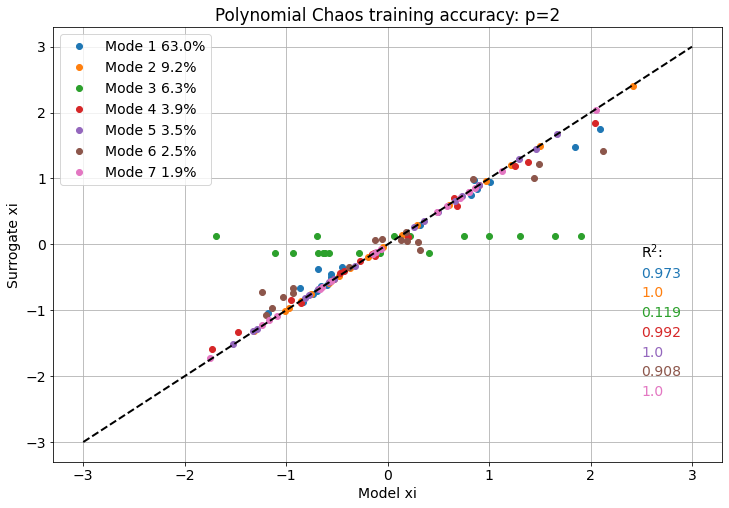

poly shape: (7,)
parameter common shape: (5,)
output shape: (7, 5)


0.38379684902135586
0.30218484195994666


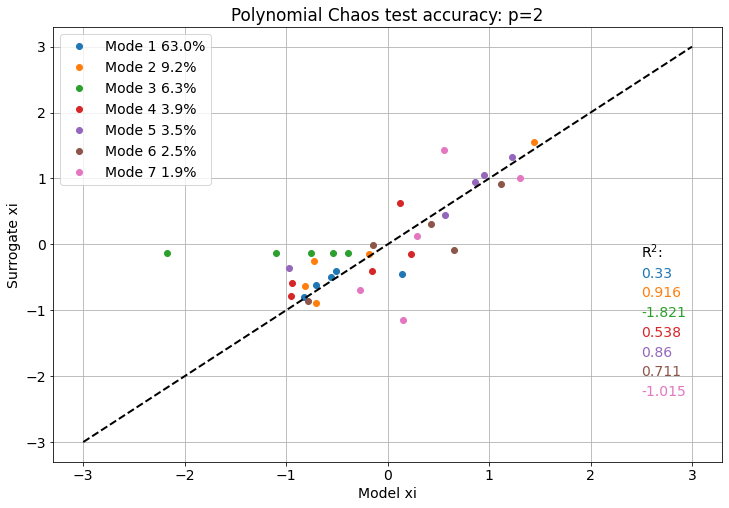

In [17]:
# Checking PC accuracy in KL space
rmse_v = 2
r2_v = -0.2
for ii in [0,1]:
    if ii == 0:
        comparison = 'training'
        klxi_pred = surrogate_model_predict(kl_surrogate['PC'],train_x)
        klxi_model = klxi_train
    else:
        comparison = 'test'
        klxi_pred = surrogate_model_predict(kl_surrogate['PC'],test_x)
        klxi_model = klxi_test
        
    #variance-weighted RMSE
    rmse = sqrt((eigenratio*(klxi_pred - klxi_model)**2).sum(axis=1).mean())
    print(rmse)
    #variance-weighted R2
    u = (eigenvalues*(klxi_model - klxi_pred)**2).sum()
    v = (eigenvalues*(klxi_model - klxi_model.mean(axis=0))**2).sum()
    r2 = 1 - u/v
    print(r2)
    
    fig = plt.figure(figsize=(12,8))
    #plt.text(2.5,rmse_v,'RMSE:')
    plt.text(2.5,r2_v,'R$^2$:')
    for iout in range(neig):
        py = plt.plot(klxi_model[:,iout], klxi_pred[:, iout], 
                      'o',label=f'Mode {iout+1} {eigenratio[iout]*100:.1f}%')
        rmse = sqrt(sum((klxi_pred[:, iout] - klxi_model[:,iout])**2))
        u = ((klxi_model[:,iout] - klxi_pred[:, iout])**2).sum()
        v = ((klxi_model[:,iout] - klxi_model[:,iout].mean())**2).sum()
        r2 = 1 - u/v
        #plt.text(2.5,rmse_v-(iout+1)*0.3,str(round(rmse,2)),color=py[0].get_color())
        plt.text(2.5,r2_v-(iout+1)*0.3,str(round(r2,3)),color=py[0].get_color())
    plt.plot([-3,3], [-3,3], 'k--', lw=2)
    plt.xlabel('Model xi')
    plt.ylabel('Surrogate xi')
    plt.title(f'Polynomial Chaos {comparison} accuracy: p={polynomial_order}')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

### Train and check the NN model

Fold 0:
  Train: index=[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17]
  Test:  index=[0 1 2 3]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.590188   1.039988   0.698081     0.698081(0)   0.000500
       100        300   0.780464   0.601291   0.524004     0.524004(99)   0.000500
       200        600   0.356184   0.303680   0.428215     0.428215(199)   0.000500
       300        900   0.197409   0.186376   0.283954     0.283954(299)   0.000500
       400       1200   0.230700   0.129785   0.217030     0.217030(399)   0.000500
       500       1500   0.046528   0.099476   0.189182     0.189182(499)   0.000500
       600       1800   0.155774   0.076783   0.179237     0.179237(599)   0.000500
       700       2100   0.054219   0.057788   0.175422     0.174940(690)   0.000500
       800       2400   0.024549   0.042046   0.165193     0.165193(799)   0.000500
       900       2700   0.032585   0.029313   0.154164     0.153524(895) 

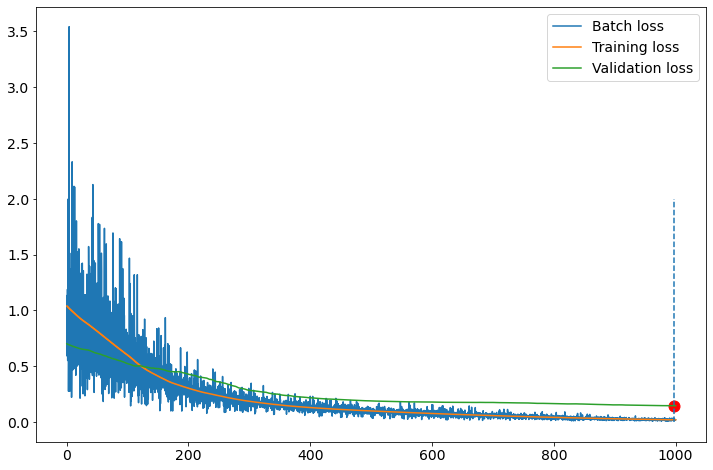

      1100       3300   0.010561   0.013438   0.145864     0.144074(1051)   0.000500
      1200       3600   0.005080   0.009182   0.152082     0.144074(1051)   0.000500
      1300       3900   0.012749   0.006508   0.159164     0.144074(1051)   0.000500
      1400       4200   0.004668   0.004628   0.167130     0.144074(1051)   0.000500
      1500       4500   0.005932   0.003354   0.177909     0.144074(1051)   0.000500
      1600       4800   0.001228   0.002476   0.190979     0.144074(1051)   0.000500
      1700       5100   0.004174   0.001781   0.203612     0.144074(1051)   0.000500
      1800       5400   0.002893   0.001255   0.215390     0.144074(1051)   0.000500
      1900       5700   0.000677   0.000854   0.224797     0.144074(1051)   0.000500
      2000       6000   0.001785   0.000549   0.232947     0.144074(1051)   0.000500


<Figure size 432x288 with 0 Axes>

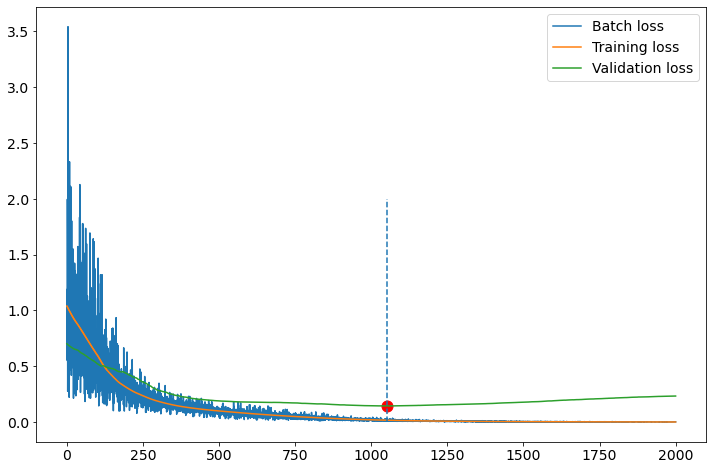

      2100       6300   0.000171   0.000327   0.235640     0.144074(1051)   0.000500
      2200       6600   0.000546   0.000183   0.237787     0.144074(1051)   0.000500
      2300       6900   0.000039   0.000094   0.238495     0.144074(1051)   0.000500
      2400       7200   0.000020   0.000046   0.238361     0.144074(1051)   0.000500
      2500       7500   0.000022   0.000020   0.237416     0.144074(1051)   0.000500
      2600       7800   0.000004   0.000008   0.236534     0.144074(1051)   0.000500
      2700       8100   0.000001   0.000002   0.235919     0.144074(1051)   0.000500
      2800       8400   0.000001   0.000001   0.235388     0.144074(1051)   0.000500
      2900       8700   0.000000   0.000000   0.234919     0.144074(1051)   0.000500
      3000       9000   0.000000   0.000000   0.234781     0.144074(1051)   0.000500


<Figure size 432x288 with 0 Axes>

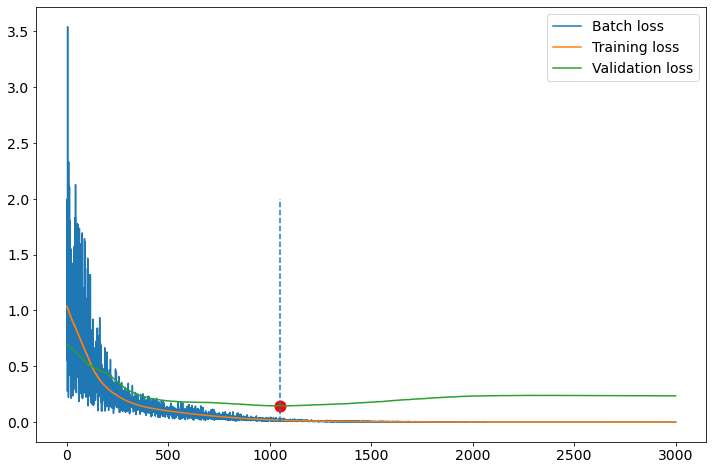

Fold 1:
  Train: index=[ 0  1  2  3  8  9 10 11 12 13 14 15 16 17]
  Test:  index=[4 5 6 7]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   1.420432   0.961558   0.681905     0.678026(0)   0.000500
       100        300   0.937336   0.479188   0.597557     0.597557(99)   0.000500
       200        600   0.102058   0.240641   0.571437     0.553219(162)   0.000500
       300        900   0.095017   0.164392   0.599343     0.553219(162)   0.000500
       400       1200   0.158607   0.110844   0.630461     0.553219(162)   0.000500
       500       1500   0.066099   0.074138   0.662990     0.553219(162)   0.000500
       600       1800   0.043231   0.052549   0.679087     0.553219(162)   0.000500
       700       2100   0.032572   0.039093   0.698536     0.553219(162)   0.000500
       800       2400   0.029832   0.029567   0.708511     0.553219(162)   0.000500
       900       2700   0.015564   0.021955   0.707612     0.553219(162) 

<Figure size 432x288 with 0 Axes>

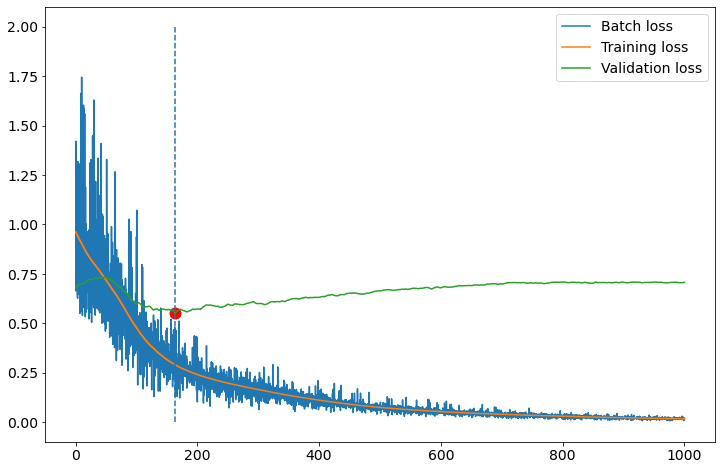

      1100       3300   0.004854   0.012009   0.703496     0.553219(162)   0.000500
      1200       3600   0.009920   0.008966   0.698695     0.553219(162)   0.000500
      1300       3900   0.005947   0.006690   0.691589     0.553219(162)   0.000500
      1400       4200   0.007095   0.004878   0.684087     0.553219(162)   0.000500
      1500       4500   0.001413   0.003511   0.673759     0.553219(162)   0.000500
      1600       4800   0.002966   0.002451   0.664438     0.553219(162)   0.000500
      1700       5100   0.001071   0.001682   0.657985     0.553219(162)   0.000500
      1800       5400   0.000480   0.001103   0.658017     0.553219(162)   0.000500
      1900       5700   0.000230   0.000695   0.660335     0.553219(162)   0.000500
      2000       6000   0.001755   0.000419   0.664036     0.553219(162)   0.000500


<Figure size 432x288 with 0 Axes>

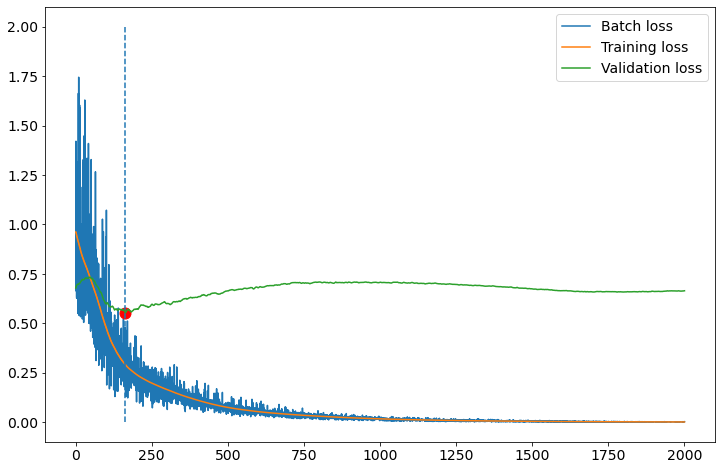

      2100       6300   0.000027   0.000237   0.668407     0.553219(162)   0.000500
      2200       6600   0.000258   0.000125   0.672122     0.553219(162)   0.000500
      2300       6900   0.000018   0.000062   0.674142     0.553219(162)   0.000500
      2400       7200   0.000009   0.000028   0.675355     0.553219(162)   0.000500
      2500       7500   0.000009   0.000012   0.676307     0.553219(162)   0.000500
      2600       7800   0.000000   0.000005   0.676779     0.553219(162)   0.000500
      2700       8100   0.000003   0.000002   0.677112     0.553219(162)   0.000500
      2800       8400   0.000001   0.000001   0.677196     0.553219(162)   0.000500
      2900       8700   0.000001   0.000000   0.677262     0.553219(162)   0.000500
      3000       9000   0.000000   0.000000   0.677180     0.553219(162)   0.000500


<Figure size 432x288 with 0 Axes>

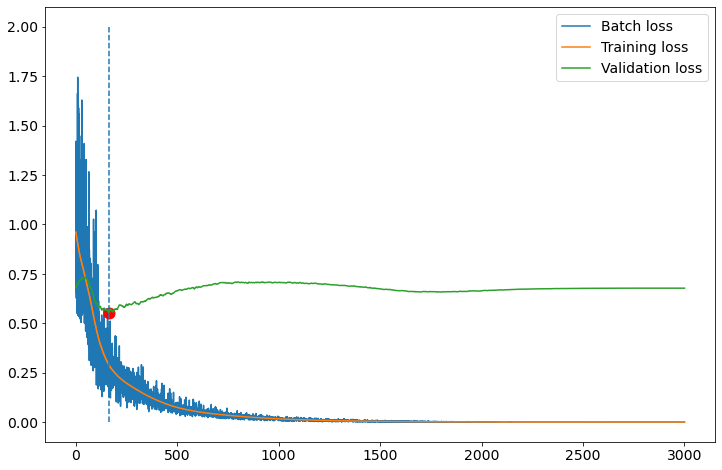

Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7 12 13 14 15 16 17]
  Test:  index=[ 8  9 10 11]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.655281   0.971068   0.611523     0.609427(0)   0.000500
       100        300   0.712087   0.547457   0.537205     0.536098(92)   0.000500
       200        600   0.363473   0.266748   0.505782     0.503768(194)   0.000500
       300        900   0.134735   0.179254   0.478285     0.478285(299)   0.000500
       400       1200   0.201207   0.138691   0.451177     0.451026(398)   0.000500
       500       1500   0.154403   0.111991   0.428083     0.428004(498)   0.000500
       600       1800   0.064964   0.089919   0.407865     0.407735(598)   0.000500
       700       2100   0.105557   0.068387   0.397439     0.397439(699)   0.000500
       800       2400   0.045894   0.048636   0.388525     0.386445(779)   0.000500
       900       2700   0.020892   0.033369   0.387490     0.384271(8

<Figure size 432x288 with 0 Axes>

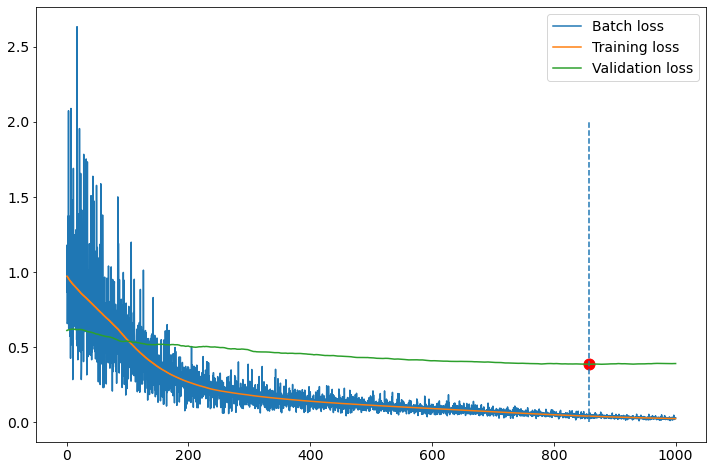

      1100       3300   0.019699   0.016242   0.396600     0.384271(857)   0.000500
      1200       3600   0.009064   0.012023   0.402187     0.384271(857)   0.000500
      1300       3900   0.010481   0.009153   0.413367     0.384271(857)   0.000500
      1400       4200   0.011590   0.006931   0.426489     0.384271(857)   0.000500
      1500       4500   0.008454   0.005149   0.437908     0.384271(857)   0.000500
      1600       4800   0.004431   0.003757   0.446266     0.384271(857)   0.000500
      1700       5100   0.001592   0.002712   0.446848     0.384271(857)   0.000500
      1800       5400   0.000402   0.001950   0.449120     0.384271(857)   0.000500
      1900       5700   0.000172   0.001389   0.450183     0.384271(857)   0.000500
      2000       6000   0.001796   0.001018   0.449912     0.384271(857)   0.000500


<Figure size 432x288 with 0 Axes>

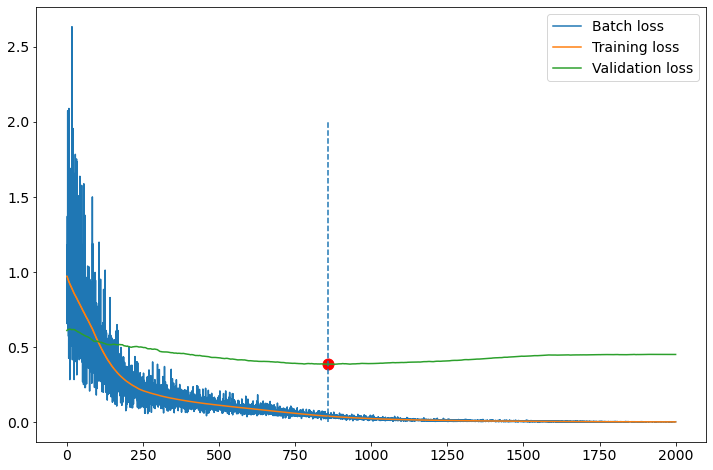

      2100       6300   0.001003   0.000767   0.449398     0.384271(857)   0.000500
      2200       6600   0.000463   0.000571   0.448175     0.384271(857)   0.000500
      2300       6900   0.000444   0.000430   0.447924     0.384271(857)   0.000500
      2400       7200   0.000454   0.000327   0.448647     0.384271(857)   0.000500
      2500       7500   0.000372   0.000250   0.450584     0.384271(857)   0.000500
      2600       7800   0.000269   0.000188   0.452653     0.384271(857)   0.000500
      2700       8100   0.000144   0.000138   0.454959     0.384271(857)   0.000500
      2800       8400   0.000125   0.000101   0.458759     0.384271(857)   0.000500
      2900       8700   0.000084   0.000069   0.461799     0.384271(857)   0.000500
      3000       9000   0.000053   0.000047   0.464318     0.384271(857)   0.000500


<Figure size 432x288 with 0 Axes>

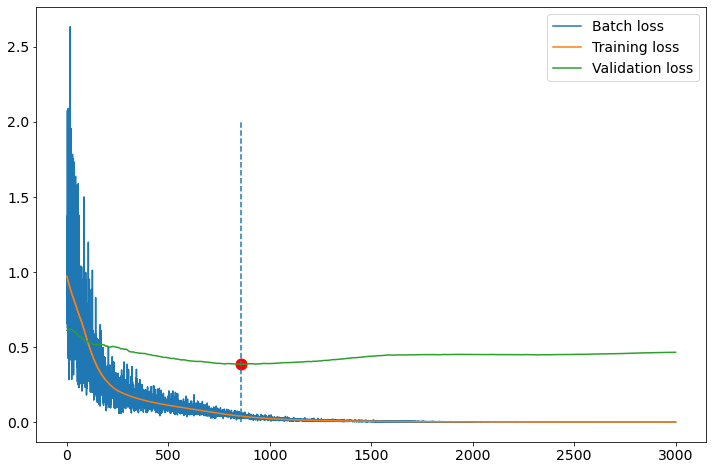

Fold 3:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 15 16 17]
  Test:  index=[12 13 14]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.330103   0.768357   1.512574     1.512420(0)   0.000500
       100        300   0.442023   0.377579   1.175331     1.175331(99)   0.000500
       200        600   0.108470   0.156954   0.811379     0.811379(199)   0.000500
       300        900   0.059652   0.090359   0.748522     0.748343(296)   0.000500
       400       1200   0.068422   0.060629   0.719901     0.719901(399)   0.000500
       500       1500   0.036476   0.040116   0.693476     0.693476(499)   0.000500
       600       1800   0.018210   0.026705   0.666701     0.666701(599)   0.000500
       700       2100   0.021051   0.018386   0.644386     0.644386(699)   0.000500
       800       2400   0.016466   0.013249   0.623476     0.623476(799)   0.000500
       900       2700   0.014854   0.009616   0.608140     0.608140(8

<Figure size 432x288 with 0 Axes>

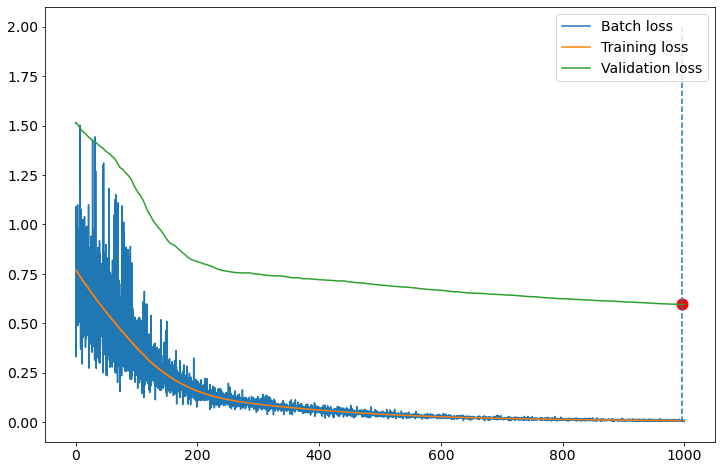

      1100       3300   0.004833   0.004712   0.590121     0.589166(1087)   0.000500
      1200       3600   0.001704   0.003117   0.592752     0.589098(1109)   0.000500
      1300       3900   0.004476   0.001999   0.599378     0.589098(1109)   0.000500
      1400       4200   0.000990   0.001260   0.608986     0.589098(1109)   0.000500
      1500       4500   0.001165   0.000827   0.618967     0.589098(1109)   0.000500
      1600       4800   0.000209   0.000557   0.630088     0.589098(1109)   0.000500
      1700       5100   0.000820   0.000396   0.641019     0.589098(1109)   0.000500
      1800       5400   0.000202   0.000299   0.649234     0.589098(1109)   0.000500
      1900       5700   0.000377   0.000230   0.655313     0.589098(1109)   0.000500
      2000       6000   0.000358   0.000176   0.656928     0.589098(1109)   0.000500


<Figure size 432x288 with 0 Axes>

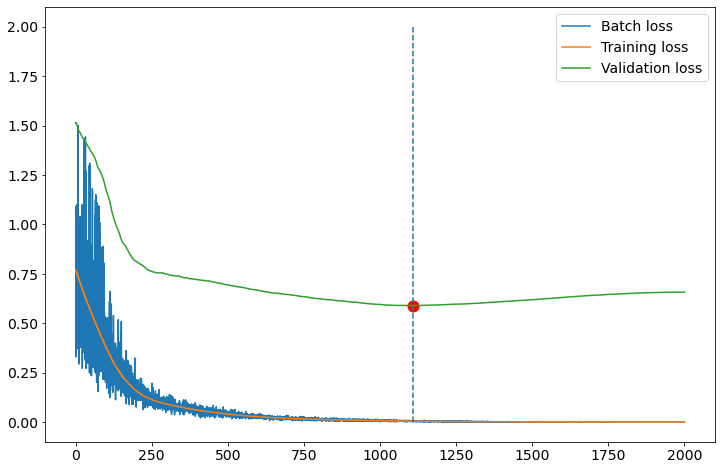

      2100       6300   0.000249   0.000130   0.657629     0.589098(1109)   0.000500
      2200       6600   0.000194   0.000091   0.657970     0.589098(1109)   0.000500
      2300       6900   0.000129   0.000059   0.657851     0.589098(1109)   0.000500
      2400       7200   0.000011   0.000034   0.657441     0.589098(1109)   0.000500
      2500       7500   0.000027   0.000017   0.656705     0.589098(1109)   0.000500
      2600       7800   0.000011   0.000008   0.655825     0.589098(1109)   0.000500
      2700       8100   0.000000   0.000003   0.655142     0.589098(1109)   0.000500
      2800       8400   0.000000   0.000001   0.654580     0.589098(1109)   0.000500
      2900       8700   0.000000   0.000000   0.654387     0.589098(1109)   0.000500
      3000       9000   0.000000   0.000000   0.654183     0.589098(1109)   0.000500


<Figure size 432x288 with 0 Axes>

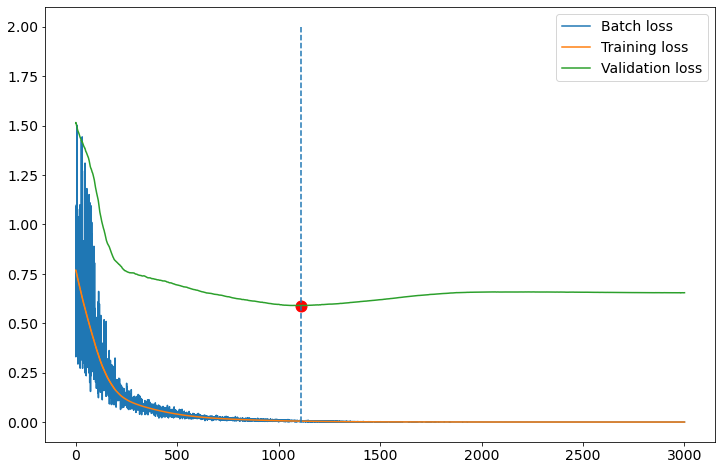

Fold 4:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
  Test:  index=[15 16 17]
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.793869   0.838293   1.233942     1.232346(0)   0.000500
       100        300   0.587288   0.427482   1.228170     1.228170(99)   0.000500
       200        600   0.197750   0.193802   1.121608     1.118266(174)   0.000500
       300        900   0.171364   0.125782   1.179812     1.118266(174)   0.000500
       400       1200   0.074556   0.095704   1.239286     1.118266(174)   0.000500
       500       1500   0.101082   0.072886   1.268653     1.118266(174)   0.000500
       600       1800   0.048137   0.053755   1.306309     1.118266(174)   0.000500
       700       2100   0.028668   0.037103   1.291001     1.118266(174)   0.000500
       800       2400   0.026360   0.024463   1.307199     1.118266(174)   0.000500
       900       2700   0.016784   0.016168   1.340190     1.118266(1

<Figure size 432x288 with 0 Axes>

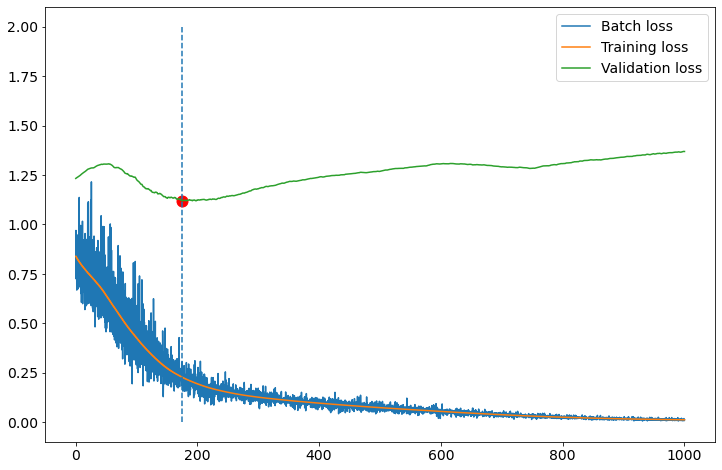

      1100       3300   0.009534   0.008414   1.393139     1.118266(174)   0.000500
      1200       3600   0.004522   0.006332   1.407751     1.118266(174)   0.000500
      1300       3900   0.004869   0.004753   1.412944     1.118266(174)   0.000500
      1400       4200   0.001280   0.003541   1.410263     1.118266(174)   0.000500
      1500       4500   0.002575   0.002553   1.385187     1.118266(174)   0.000500
      1600       4800   0.001822   0.001812   1.357466     1.118266(174)   0.000500
      1700       5100   0.001162   0.001292   1.328955     1.118266(174)   0.000500
      1800       5400   0.002040   0.000914   1.304382     1.118266(174)   0.000500
      1900       5700   0.000635   0.000632   1.279788     1.118266(174)   0.000500
      2000       6000   0.000626   0.000425   1.255930     1.118266(174)   0.000500


<Figure size 432x288 with 0 Axes>

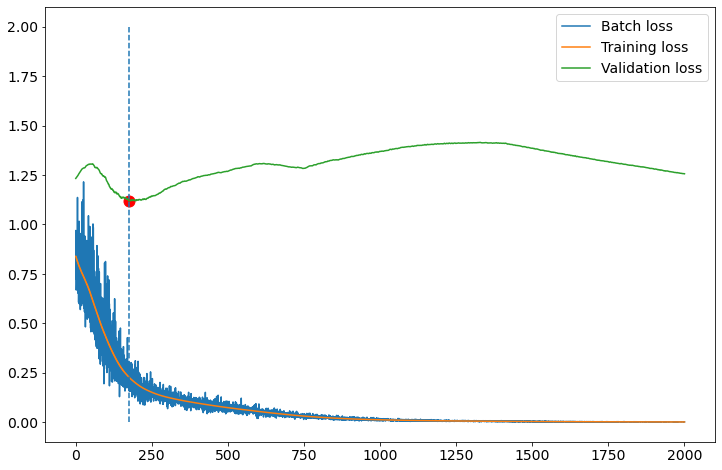

      2100       6300   0.000295   0.000264   1.232458     1.118266(174)   0.000500
      2200       6600   0.000029   0.000150   1.215644     1.118266(174)   0.000500
      2300       6900   0.000045   0.000082   1.209501     1.118266(174)   0.000500
      2400       7200   0.000036   0.000041   1.204537     1.118266(174)   0.000500
      2500       7500   0.000010   0.000018   1.201898     1.118266(174)   0.000500
      2600       7800   0.000023   0.000007   1.200306     1.118266(174)   0.000500
      2700       8100   0.000000   0.000002   1.200140     1.118266(174)   0.000500
      2800       8400   0.000002   0.000001   1.200212     1.118266(174)   0.000500
      2900       8700   0.000000   0.000000   1.200589     1.118266(174)   0.000500
      3000       9000   0.000000   0.000000   1.200978     1.118266(174)   0.000500


<Figure size 432x288 with 0 Axes>

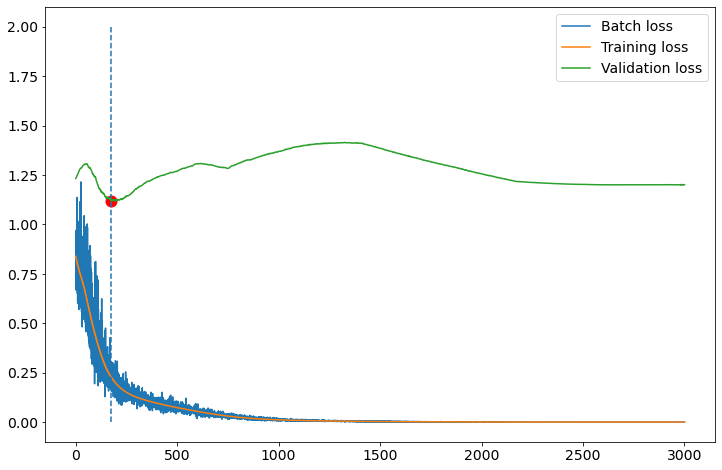

<Figure size 432x288 with 0 Axes>

In [18]:
# Neural Network
kl_surrogate['NN'] = make_nn_surrogate_model(
    train_x.values, klxi_train.astype(float),
    cv='KFold',
    #cv='LOO',
    #test_X=test_x.values, test_Y=klxi_test,
    num_hidden_layers=hidden_layers,
    lrate=learn_rate,
    batch_size=batch_size,
    nepochs=nepochs,
    seed=random_seed,
    eigenratio=eigenratio,
)

0.15693291306664262
0.9711423195637666


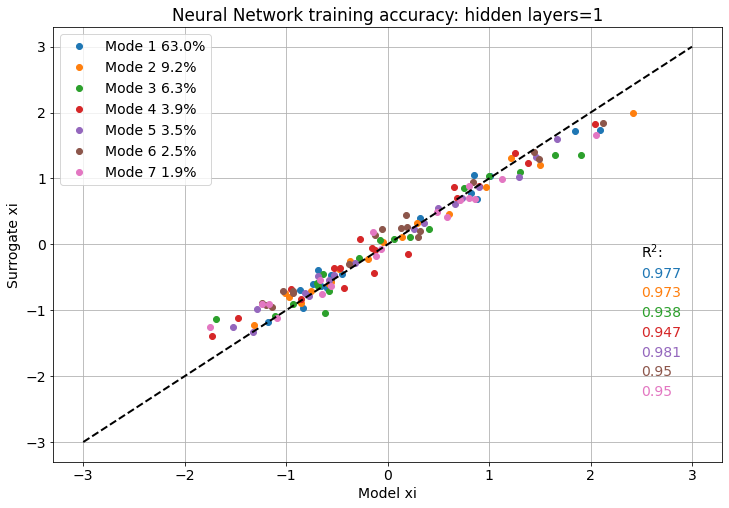

0.4926565675385925
-0.14981017901706029


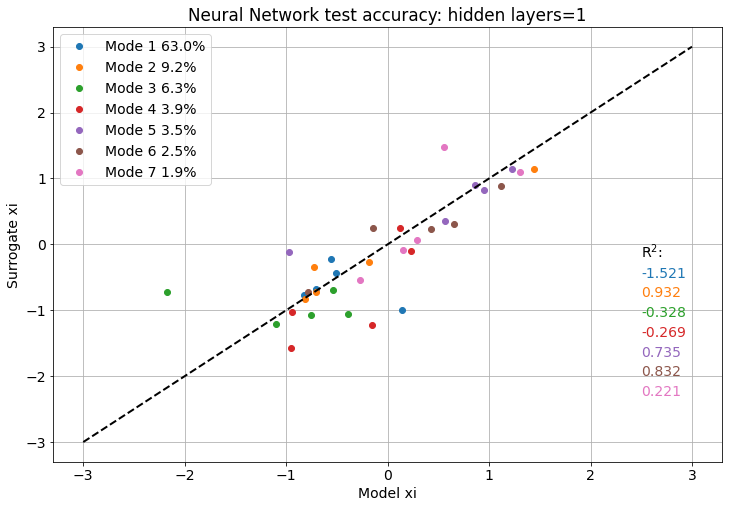

In [19]:
# Checking NN accuracy in KL space
rmse_v = 2
r2_v = -0.2
for ii in [0,1]:
    if ii == 0:
        comparison = 'training'
        klxi_model = klxi_train
        klxi_pred = surrogate_model_predict(kl_surrogate['NN'],train_x.values)
    else:
        comparison = 'test'
        klxi_model = klxi_test
        klxi_pred = surrogate_model_predict(kl_surrogate['NN'],test_x.values)
        
    #variance-weighted RMSE
    rmse = sqrt((eigenratio*(klxi_pred - klxi_model)**2).sum(axis=1).mean())
    print(rmse)
    #variance-weighted R2
    u = (eigenvalues*(klxi_model - klxi_pred)**2).sum()
    v = (eigenvalues*(klxi_model - klxi_model.mean(axis=0))**2).sum()
    r2 = 1 - u/v
    print(r2)
        
        
    fig = plt.figure(figsize=(12,8))
    #plt.text(2.5,rmse_v,'RMSE:')
    plt.text(2.5,r2_v,'R$^2$:')
    for iout in range(neig):
        py = plt.plot(klxi_model[:,iout], klxi_pred[:, iout], 
                      'o',label=f'Mode {iout+1} {eigenratio[iout]*100:.1f}%')
        rmse = sqrt(sum((klxi_pred[:, iout] - klxi_model[:,iout])**2))
        u = ((klxi_model[:,iout] - klxi_pred[:, iout])**2).sum()
        v = ((klxi_model[:,iout] - klxi_model[:,iout].mean())**2).sum()
        r2 = 1 - u/v
        #plt.text(2.5,rmse_v-(iout+1)*0.3,str(round(rmse,2)),color=py[0].get_color())
        plt.text(2.5,r2_v-(iout+1)*0.3,str(round(r2,3)),color=py[0].get_color())
    plt.plot([-3,3], [-3,3], 'k--', lw=2)
    plt.xlabel('Model xi')
    plt.ylabel('Surrogate xi')
    plt.title(f'Neural Network {comparison} accuracy: hidden layers={hidden_layers}')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

poly shape: (7,)
parameter common shape: (18,)
output shape: (7, 18)
poly shape: (7,)
parameter common shape: (5,)
output shape: (7, 5)


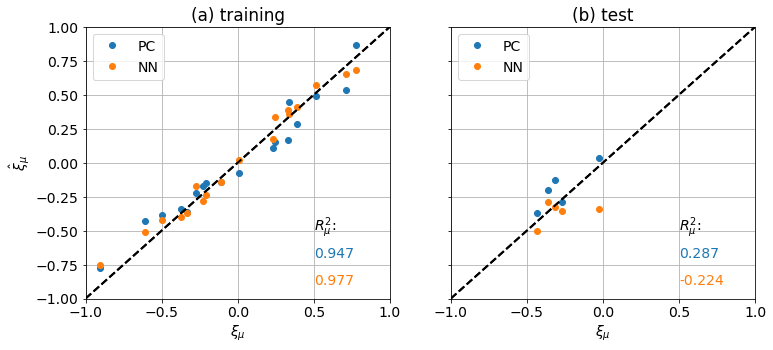

In [20]:
# Checking PC and NN accuracy for sqrt(eigenvalue)-weighted combined
def weighted_value(value,weights):
    return (weights*value).sum(axis=1)/weights.sum()

rmse_v = 2
r2_v = -0.5
bnds = 1

fig, axs = plt.subplots(1, 2,sharey=True,figsize=(12,5))

for ii in [0,1]:
    
    if ii == 0:
        comparison = '(a) training'
        klxi_model = klxi_train
        # pc
        klxi_pred0 = surrogate_model_predict(kl_surrogate['PC'],train_x)
        # nn
        klxi_pred = surrogate_model_predict(kl_surrogate['NN'],train_x.values)
        #zeros(klxi_model.shape)
        #n_folds = len(kl_surrogate['NN'])
        #for fold_surrogate in kl_surrogate['NN']:
        #    klxi_pred += surrogate_model_predict(fold_surrogate,train_x.values)
        #klxi_pred = klxi_pred / n_folds
    else:
        comparison = '(b) test'
        
        klxi_model = klxi_test
        # pc
        klxi_pred0 = surrogate_model_predict(kl_surrogate['PC'],test_x)
        # nn
        klxi_pred = surrogate_model_predict(kl_surrogate['NN'],test_x.values)
        #klxi_pred = zeros(klxi_model.shape)
        #n_folds = len(kl_surrogate['NN'])
        #for fold_surrogate in kl_surrogate['NN']:
        #    klxi_pred += surrogate_model_predict(fold_surrogate,test_x.values)
        #klxi_pred = klxi_pred / n_folds
    
    weighting = sqrt(eigenvalues)
    #weighting = eigenvalues
    
    model_w = weighted_value(klxi_model,weighting) 
    pred_w = {'NN':  zeros(model_w.shape),'PC':  zeros(model_w.shape)}
    pred_w['NN'] = weighted_value(klxi_pred,weighting) 
    pred_w['PC'] = weighted_value(klxi_pred0,weighting) 
    
    axs[ii].text(bnds-0.5,r2_v,'$R^2_\mu$:')
    for st,surrogate_type in enumerate(['PC','NN']):
        py = axs[ii].plot(model_w, pred_w[surrogate_type], 
                          'o',label=surrogate_type)
        u = ((model_w - pred_w[surrogate_type])**2).sum()
        v = ((model_w - model_w.mean())**2).sum()
        r2 = 1 - u/v
        axs[ii].text(bnds-0.5,r2_v-(1+st)*0.2,str(round(r2,3)),color=py[0].get_color())
        axs[ii].plot([-bnds,bnds], [-bnds,bnds], 'k--', lw=2)
    axs[ii].set_xlabel(r'$\xi_\mu$')
    if ii == 0:
        axs[ii].set_ylabel(r'$\hat{\xi}_\mu$')
    axs[ii].set_xlim([-bnds,bnds])
    axs[ii].set_ylim([-bnds,bnds])
    axs[ii].set_title(f'{comparison}')
    axs[ii].legend(loc='upper left')
    axs[ii].grid()
plt.show()

poly shape: (7,)
parameter common shape: (18,)
output shape: (7, 18)
poly shape: (7,)
parameter common shape: (5,)
output shape: (7, 5)


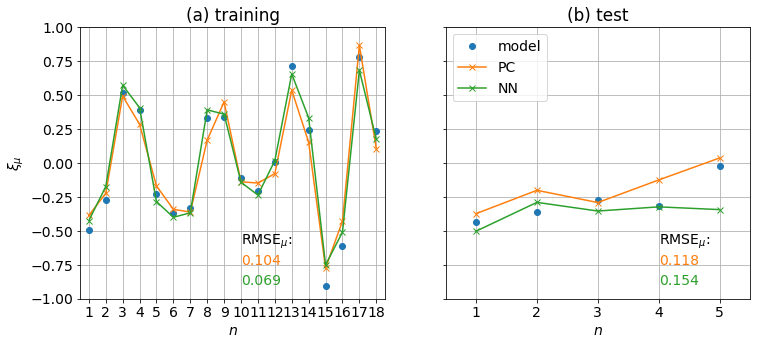

In [21]:
# Checking PC and NN accuracy for sqrt(eigenvalue)-weighted combined
def weighted_value(value,weights):
    return (weights*value).sum(axis=1)/weights.sum()

rmse_v = 2
r2_v = -0.6
bnds = 1

fig, axs = plt.subplots(1, 2,sharey=True,figsize=(12,5))

for ii in [0,1]:
    
    if ii == 0:
        comparison = '(a) training'
        ind=arange(1, train_x.shape[0]+1)
        klxi_model = klxi_train
        # pc
        klxi_pred0 = surrogate_model_predict(kl_surrogate['PC'],train_x)
        # nn
        klxi_pred = surrogate_model_predict(kl_surrogate['NN'],train_x.values)
        #zeros(klxi_model.shape)
        #n_folds = len(kl_surrogate['NN'])
        #for fold_surrogate in kl_surrogate['NN']:
        #    klxi_pred += surrogate_model_predict(fold_surrogate,train_x.values)
        #klxi_pred = klxi_pred / n_folds
    else:
        comparison = '(b) test'
        ind=arange(1, test_x.shape[0]+1)
        klxi_model = klxi_test
        # pc
        klxi_pred0 = surrogate_model_predict(kl_surrogate['PC'],test_x)
        # nn
        klxi_pred = surrogate_model_predict(kl_surrogate['NN'],test_x.values)
        #klxi_pred = zeros(klxi_model.shape)
        #n_folds = len(kl_surrogate['NN'])
        #for fold_surrogate in kl_surrogate['NN']:
        #    klxi_pred += surrogate_model_predict(fold_surrogate,test_x.values)
        #klxi_pred = klxi_pred / n_folds
    
    weighting = sqrt(eigenvalues)
    #weighting = eigenvalues
    
    model_w = weighted_value(klxi_model,weighting) 
    pred_w = {'NN':  zeros(model_w.shape),'PC':  zeros(model_w.shape)}
    pred_w['NN'] = weighted_value(klxi_pred,weighting) 
    pred_w['PC'] = weighted_value(klxi_pred0,weighting) 
    
    axs[ii].plot(ind,model_w,'o',label='model')
    
    axs[ii].text(10-ii*6,r2_v,'RMSE$_\mu$:')
    for st,surrogate_type in enumerate(['PC','NN']):
        py = axs[ii].plot(ind,pred_w[surrogate_type], 
                          'x-',label=surrogate_type)
        rmse = sqrt(((model_w - pred_w[surrogate_type])**2).mean())
        axs[ii].text(10-ii*6,r2_v-(1+st)*0.15,str(round(rmse,3)),color=py[0].get_color())
    axs[ii].set_xlabel(r'$n$')
    if ii == 0:
        axs[ii].set_ylabel(r'$\xi_\mu$')
    else:
        axs[ii].legend(loc='upper left')
    axs[ii].set_xlim([ind[0]-0.5,ind[-1]+0.5])
    axs[ii].set_xticks(ind)
    axs[ii].set_ylim([-bnds,bnds])
    axs[ii].set_title(f'{comparison}')
    
    axs[ii].grid()
plt.show()

## Global Sensitivity Analysis

In [22]:
total_var_sens = {'PC': {'main': [], 'total': []}, 'NN': {'main': [], 'total': []}}

### GSA on PC model

In [23]:
# get the sensitivity for the PC surrogate
sens_eig_sobol, pc_min, pc_max = compute_sensitivities(kl_surrogate['PC'], train_x, sample_size=10000)

for sens_label in ['main','total']:
    portion_of_eigen_explain = sens_eig_sobol[sens_label] #/sens_eig_sobol[sens_label].sum(axis=1).reshape(-1,1)
    portion_of_eigen_explain[isnan(portion_of_eigen_explain)] = 0
    total_var_sens['PC'][sens_label] = (portion_of_eigen_explain * eigenratio.reshape(-1,1)).sum(axis=0)

Initializing SOBOL
Sampling SOBOL


poly shape: (7,)
parameter common shape: (220000,)
output shape: (7, 220000)


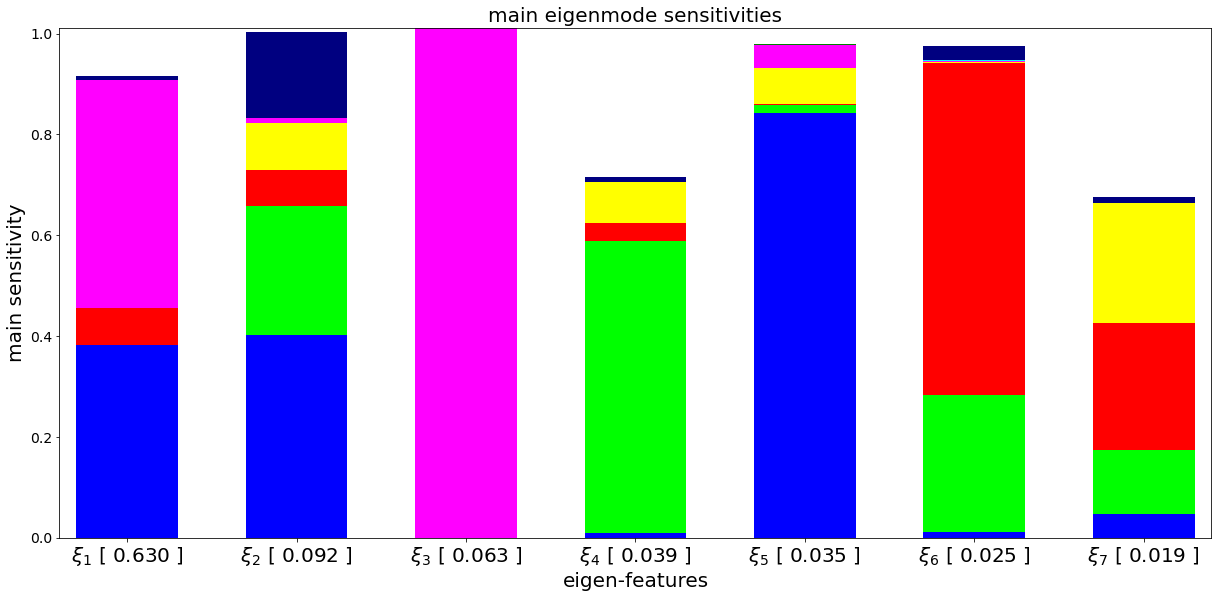

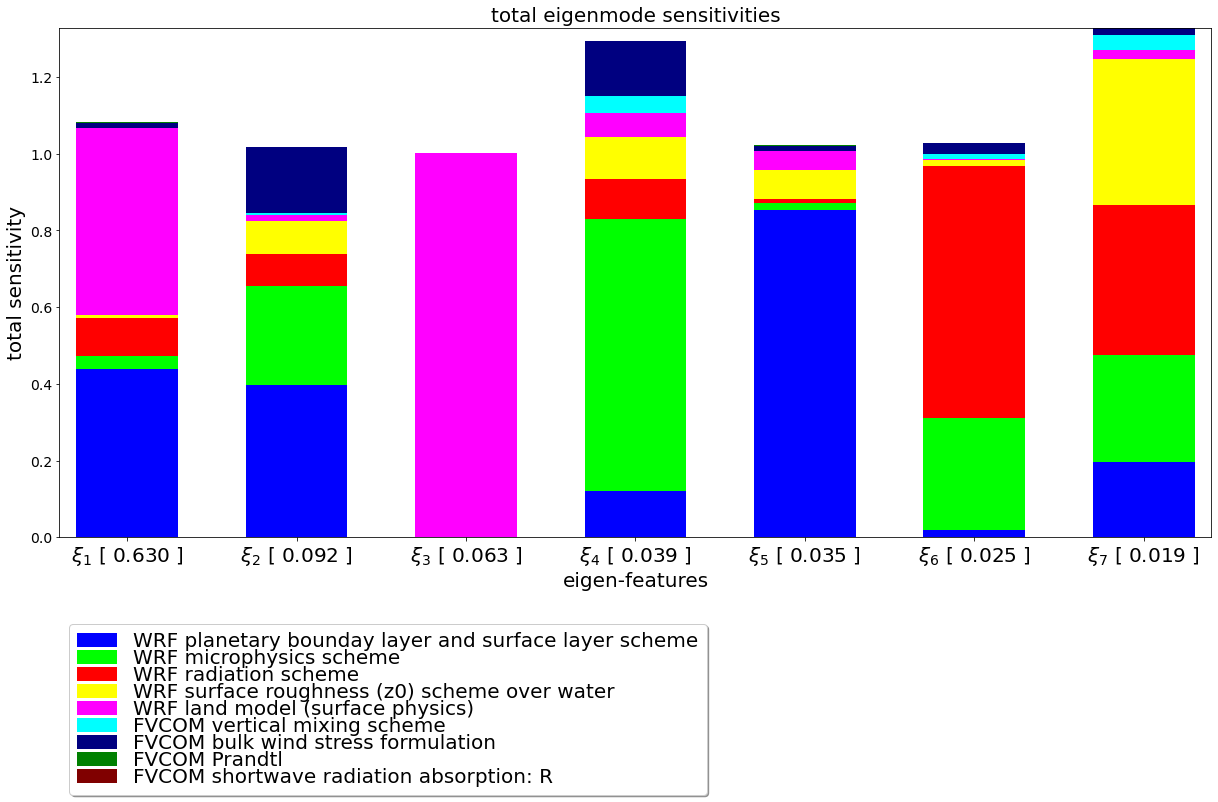

In [24]:
# Plot eigenmode sensitivities for PC
case_labels = [rf'$\xi_{str(j+1)}$ [ {eigenratio[j]:.3f} ]' for j in range(neig)]
#case_labels.append(r'$\xi_{ALL}$')
plot_sens(#append(sens_eig_sobol['main'],total_var_sens['main'].reshape(1,-1),axis=0)
          sens_eig_sobol['main'],
          range(len(variables)),range(neig),
          vis="bar",reverse=False,
          par_labels=pnames,
          case_labels=case_labels,
          colors=[],ncol=5,grid_show=False,
          xlbl='eigen-features',ylbl='main sensitivity',legend_show=0, legend_size=20, maxlegendcol=1,
          xdatatick=[],showplot=True, topsens=[], lbl_size=20, yoffset=0.01, senssort=False,
          title='main eigenmode sensitivities', xticklabel_size=20, xticklabel_rotation=0) 

plot_sens(#append(sens_eig_sobol['total'],total_var_sens['total'].reshape(1,-1),axis=0),
          sens_eig_sobol['total'],
          range(len(variables)),range(neig),
          vis="bar",reverse=False,
          par_labels=pnames,
          case_labels=case_labels,
          colors=[],ncol=5,grid_show=False,
          xlbl='eigen-features',ylbl='total sensitivity',legend_show=2,legend_size=20,maxlegendcol=1,
          xdatatick=[],showplot=True, topsens=[], lbl_size=20, yoffset=0.01, senssort=False,
          title='total eigenmode sensitivities', xticklabel_size=20, xticklabel_rotation=0) 

# Plot overall sensitivities by param
#case_labels = ['main', 'joint']
#pname_short = [str(var)[28:-2] for var in variables]
#plot_sens(append(total_var_sens['main'].reshape(1,-1),
#                 (total_var_sens['total']-total_var_sens['main']).reshape(1,-1),
#                 axis=0
#                ),
#          range(len(variables)),[0,1],vis="bar",reverse=True,
#          par_labels=pname_short,
#          case_labels=case_labels,
#          colors=[],ncol=5,grid_show=False,
#          xlbl='parameterizations/parameters',ylbl='sensitivity',ylim_max=0.5,
#          legend_show=1,legend_size=25,maxlegendcol=1,
#          xdatatick=[],showplot=True, topsens=[], lbl_size=30, yoffset=0.01, senssort=False,
#          title='overall eigenmode sensitivities', xticklabel_size=20, xticklabel_rotation=50) 

### GSA on NN model

In [25]:
# get the sensitivity for the NN surrogate
sens_eig_sobol, nn_min, nn_max = compute_sensitivities(kl_surrogate['NN'], train_x, sample_size=10000)

for sens_label in ['main','total']:
    portion_of_eigen_explain = sens_eig_sobol[sens_label] #/sens_eig_sobol[sens_label].sum(axis=1).reshape(-1,1)
    portion_of_eigen_explain[isnan(portion_of_eigen_explain)] = 0
    total_var_sens['NN'][sens_label] = (portion_of_eigen_explain * eigenratio.reshape(-1,1)).sum(axis=0)

Initializing SOBOL
Sampling SOBOL


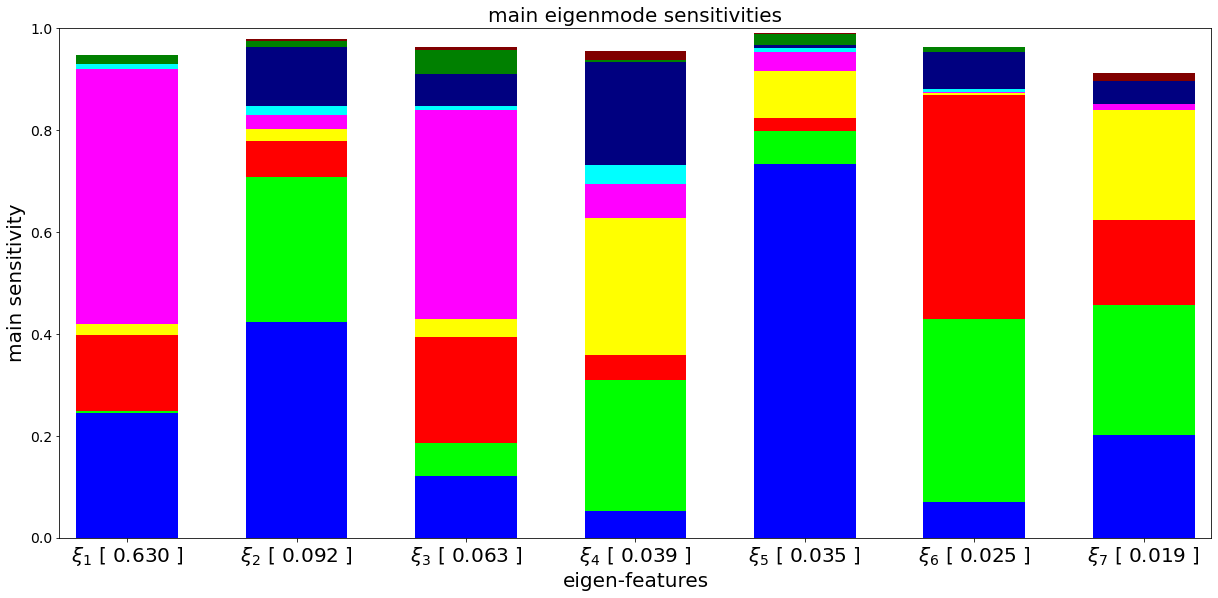

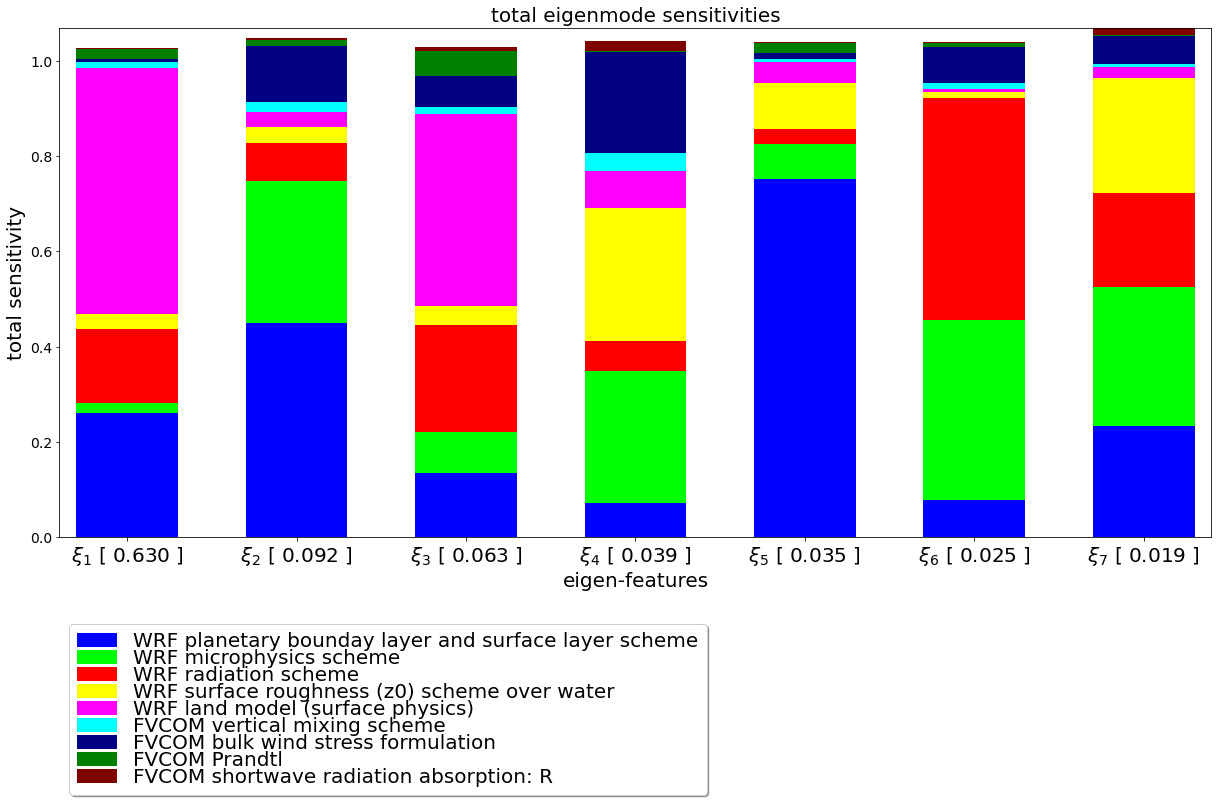

In [26]:
# Plot eigenmode sensitivities for PC
case_labels = [rf'$\xi_{str(j+1)}$ [ {eigenratio[j]:.3f} ]' for j in range(neig)]
#case_labels.append(r'$\xi_{ALL}$')
plot_sens(#append(sens_eig_sobol['main'],total_var_sens['main'].reshape(1,-1),axis=0)
          sens_eig_sobol['main'],
          range(len(variables)),range(neig),
          vis="bar",reverse=False,
          par_labels=pnames,
          case_labels=case_labels,
          colors=[],ncol=5,grid_show=False,
          xlbl='eigen-features',ylbl='main sensitivity',legend_show=0, legend_size=20, maxlegendcol=1,
          xdatatick=[],showplot=True, topsens=[], lbl_size=20, yoffset=0.01, senssort=False,
          title='main eigenmode sensitivities', xticklabel_size=20, xticklabel_rotation=0) 

plot_sens(#append(sens_eig_sobol['total'],total_var_sens['total'].reshape(1,-1),axis=0),
          sens_eig_sobol['total'],
          range(len(variables)),range(neig),
          vis="bar",reverse=False,
          par_labels=pnames,
          case_labels=case_labels,
          colors=[],ncol=5,grid_show=False,
          xlbl='eigen-features',ylbl='total sensitivity',legend_show=2,legend_size=20,maxlegendcol=1,
          xdatatick=[],showplot=True, topsens=[], lbl_size=20, yoffset=0.01, senssort=False,
          title='total eigenmode sensitivities', xticklabel_size=20, xticklabel_rotation=0) 

# Plot overall sensitivities by param
#case_labels = ['main', 'joint']
#pname_short = [str(var)[28:-2] for var in variables]
#plot_sens(append(total_var_sens['main'].reshape(1,-1),
#                 (total_var_sens['total']-total_var_sens['main']).reshape(1,-1),
#                 axis=0
#                ),
#          range(len(variables)),[0,1],vis="bar",reverse=True,
#          par_labels=pname_short,
#          case_labels=case_labels,
#          colors=[],ncol=5,grid_show=False,
#          xlbl='parameterizations/parameters',ylbl='sensitivity',ylim_max=0.5,
#          legend_show=1,legend_size=25,maxlegendcol=1,
#          xdatatick=[],showplot=True, topsens=[], lbl_size=30, yoffset=0.01, senssort=False,
#          title='overall eigenmode sensitivities', xticklabel_size=20, xticklabel_rotation=50) 

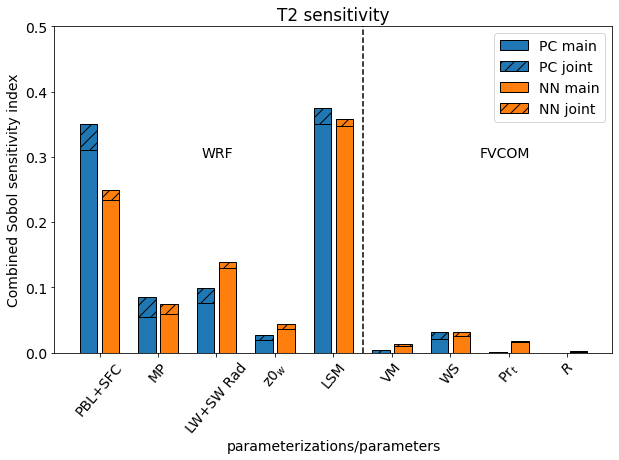

In [27]:
# Plot overall sensitivities by param
pname_paper = ['PBL+SFC', 'MP', 'LW+SW Rad', 'z0$_w$', 'LSM', 
               'VM', 'WS', 'Pr$_t$', '$R$']
case_labels = ['main', 'joint']
cases_hatch = [None,'//']
cases_color = ['#1f77b4', '#ff7f0e']
fig = plt.figure(figsize=(10, 6))
ind=arange(1, len(variables)+1)
width = 0.3
cases = [0,1]
for st,surrogate_type in enumerate(['PC','NN']):
    sensdata = append(total_var_sens[surrogate_type]['main'].reshape(1,-1),
                     (total_var_sens[surrogate_type]['total']-total_var_sens[surrogate_type]['main']).reshape(1,-1),
                     axis=0
                    ).transpose()
    curr = zeros(len(variables))
    for i in cases:
        plt.bar(ind+1.25*(st-0.5)*width,
                sensdata[:, i],
                width=width,
                color=cases_color[st],
                edgecolor='black',
                hatch=cases_hatch[i],
                bottom=curr,
                label=surrogate_type + ' ' + case_labels[i],
        )
        curr += sensdata[:, i]
plt.plot([5.5,5.5],[0,0.5],'k--')
plt.text(2.75,0.3,'WRF')
plt.text(7.5,0.3,'FVCOM')
plt.xticks(ind, pname_paper, rotation=50)
#plt.grid()
plt.ylim([0,0.5])
plt.ylabel('Combined Sobol sensitivity index')
plt.xlabel('parameterizations/parameters')
plt.title('T2 sensitivity')
plt.legend()
plt.show()   
    #print(total_var_sens[surrogate_type]['total'])
    #plot_sens(append(total_var_sens[surrogate_type]['main'].reshape(1,-1),
    #                 (total_var_sens[surrogate_type]['total']-total_var_sens[surrogate_type]['main']).reshape(1,-1),
    #                 axis=0
    #                ),
    #          range(len(variables)),[0,1],vis="bar",reverse=True,
    #          par_labels=pname_paper,
    #          case_labels=case_labels,
    #          colors=[],ncol=5,grid_show=False,
    #          xlbl='parameterizations/parameters',ylbl='sensitivity',ylim_max=0.5,
    #          legend_show=1,legend_size=25,maxlegendcol=1,
    #          xdatatick=[], # = arange(1, len(variables)+1),
    #          showplot=True, topsens=[], lbl_size=25, yoffset=0.01, senssort=False,
    #          title='overall eigenmode sensitivities', xticklabel_size=22, xticklabel_rotation=50) 

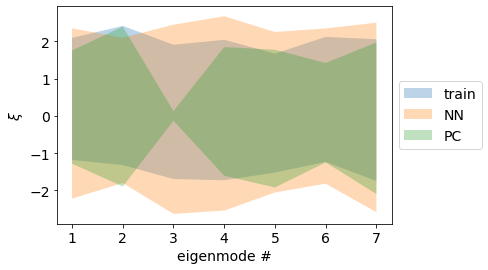

In [43]:
# compare range of PC and NN
plt.fill_between(range(1,neig+1),klxi_train.min(axis=0),klxi_train.max(axis=0),alpha=0.3,label='train')
plt.fill_between(range(1,neig+1),nn_min,nn_max,alpha=0.3,label='NN')
plt.fill_between(range(1,neig+1),pc_min,pc_max,alpha=0.3,label='PC')
plt.xticks(range(1,neig+1))
plt.ylabel(r'$\xi$')
plt.xlabel('eigenmode #')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [28]:
# convert surrogate to physical space through some algebra
pc_exponents = kl_surrogate['PC'].exponents
pc_coefficients = array(kl_surrogate['PC'].coefficients)

def get_combined_coefficients(eigenmodes_in,mean_vector_in):
    klpc_coefficients = sum(
        stack(
            [
                dot(
                    (pc_coefficients * sqrt(eigenvalues))[:, mode_index, None],
                        eigenmodes_in[None, mode_index, :],
                    )
                for mode_index in range(neig)
            ],
            axis=0,
        ),
        axis=0,
    )
    klpc_coefficients[0, :] += mean_vector_in
    return klpc_coefficients

In [40]:
# reshape the mean vector and eigenmodes so we can manipulate by dimension
mean_vector_reshape = mean_vector.reshape(ntime2,-1)
eigenmodes_reshape = eigenmodes.reshape(neig,ntime2,-1)

In [30]:
# get coefficients based on mean in temporal and spatial dimensions
coefficients_x = get_combined_coefficients(eigenmodes_reshape.mean(axis=1), mean_vector_reshape.mean(axis=0))
coefficients_t = get_combined_coefficients(eigenmodes_reshape.mean(axis=2), mean_vector_reshape.mean(axis=1))
surrogate_model_x = ndpoly.from_attributes(
    exponents=pc_exponents, coefficients=coefficients_x
)
surrogate_model_t = ndpoly.from_attributes(
    exponents=pc_exponents, coefficients=coefficients_t
)

In [31]:
sens_sobol_t = compute_sensitivities(surrogate_model_t, train_x, sample_size=10000)

poly shape: (91,)
parameter common shape: (220000,)
output shape: (91, 220000)


Initializing SOBOL
Sampling SOBOL


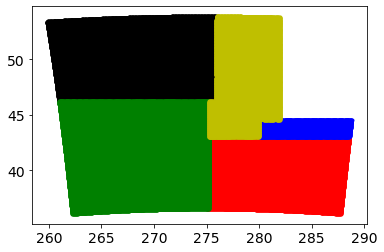

In [56]:
# get the mask for each Lake
lon = train_dict['T2'][0][1].XLONG.values + 360
lat = train_dict['T2'][0][1].XLAT.values
superior = (lat > 46.2) & (lon < 275.9)
plt.plot(lon[superior],lat[superior],'k.')
erie = (lat < 43) & (lon > 275)
plt.plot(lon[erie],lat[erie],'r.')
ontario = (lat > 43) & (lat < 44.55) & (lon > 280)
plt.plot(lon[ontario],lat[ontario],'b.')
michigan = (lat < 46.25) & (lon < 275.25)
plt.plot(lon[michigan],lat[michigan],'g.')
huron = ~((michigan) | (superior) | (erie) | (ontario)) & (lon < 282)
plt.plot(lon[huron],lat[huron],'y.')

In [59]:
lake_dict[lake].reshape(1,-1).shape

(1, 262812)

In [61]:
# get surrogate model for each lake (lake-wide mean)
lake_dict = {'Superior': superior,
             'Huron': huron,
             'Michigan': michigan,
             'Ontario': ontario,
             'Erie': erie,
            }
surrogate_model_lake = []
for lake in lake_dict:
    print(lake)
    coefficients_lake = get_combined_coefficients(
        eigenmodes_reshape[:,:,lake_dict[lake].reshape(1,-1).flatten()].mean(axis=2), 
        mean_vector_reshape[:,lake_dict[lake].reshape(1,-1).flatten()].mean(axis=1)
    )
    surrogate_model_lake.append(ndpoly.from_attributes(
        exponents=pc_exponents, coefficients=coefficients_lake
    )
                               )

Superior
Huron
Michigan
Ontario
Erie


poly shape: (91,)
parameter common shape: (220000,)
output shape: (91, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (91,)


Initializing SOBOL
Sampling SOBOL


parameter common shape: (220000,)
output shape: (91, 220000)
poly shape: (91,)
parameter common shape: (220000,)
output shape: (91, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (91,)
parameter common shape: (220000,)
output shape: (91, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (91,)
parameter common shape: (220000,)
output shape: (91, 220000)


Initializing SOBOL
Sampling SOBOL


poly shape: (91,)
parameter common shape: (220000,)
output shape: (91, 220000)


Initializing SOBOL
Sampling SOBOL


(0.0, 30.0)

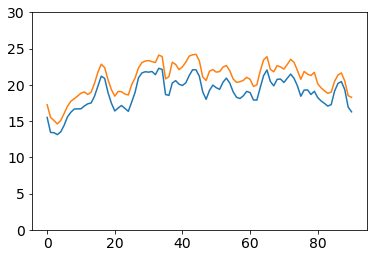

In [41]:
# get sensitivity for each lake (temporally varying)
sens_sobol_lake = [None] * (len(lake_dict)+1)
pc_ens_min = [None] * (len(lake_dict)+1)
pc_ens_max = [None] * (len(lake_dict)+1)
for ldx,surrogate_model in enumerate(surrogate_model_lake):
    # get the sensitivity for the PC surrogate
    this_sens, this_min, this_max = compute_sensitivities(surrogate_model, train_x, sample_size=10000)
    sens_sobol_lake[ldx] = this_sens
    pc_ens_min[ldx] = this_min
    pc_ens_max[ldx] = this_max
    
# overall
this_sens, this_min, this_max = compute_sensitivities(surrogate_model_t, train_x, sample_size=10000)
sens_sobol_lake[-1] = this_sens
pc_ens_min[-1] = this_min
pc_ens_max[-1] = this_max

plt.plot(this_min)
plt.plot(this_max)
plt.ylim([0, 30])

Superior
Initializing SOBOL
Sampling SOBOL
Huron
Initializing SOBOL
Sampling SOBOL
Michigan
Initializing SOBOL
Sampling SOBOL
Ontario
Initializing SOBOL
Sampling SOBOL
Erie
Initializing SOBOL
Sampling SOBOL
overall
Initializing SOBOL
Sampling SOBOL


(0.0, 30.0)

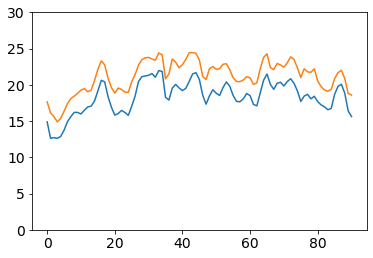

In [63]:
sens_sobol_lake = [None] * (len(lake_dict)+1)
nn_ens_min = [None] * (len(lake_dict)+1)
nn_ens_max = [None] * (len(lake_dict)+1)
for ldx,lake in enumerate(lake_dict):
    print(lake)
    
    # get the sensitivity for the PC surrogate
    kl_dict = {'eigenmodes': eigenmodes_reshape[:,:,lake_dict[lake].reshape(1,-1).flatten()].mean(axis=2),
           'eigenvalues': eigenvalues,
           'mean_vector': mean_vector_reshape[:,lake_dict[lake].reshape(1,-1).flatten()].mean(axis=1),
          }
    this_sens, this_min, this_max = compute_sensitivities(kl_surrogate['NN'], train_x, sample_size=10000,
                                                     kl_dict=kl_dict)
    sens_sobol_lake[ldx] = this_sens
    nn_ens_min[ldx] = this_min
    nn_ens_max[ldx] = this_max
    
# overall
print('overall')
kl_dict = {'eigenmodes': eigenmodes_reshape.mean(axis=2), 
           'eigenvalues': eigenvalues,
           'mean_vector': mean_vector_reshape.mean(axis=1),
          }
this_sens, this_min, this_max = compute_sensitivities(kl_surrogate['NN'], train_x, sample_size=10000,
                                                     kl_dict=kl_dict)
sens_sobol_lake[-1] = this_sens
nn_ens_min[-1] = this_min
nn_ens_max[-1] = this_max

plt.plot(this_min)
plt.plot(this_max)
plt.ylim([0, 30])

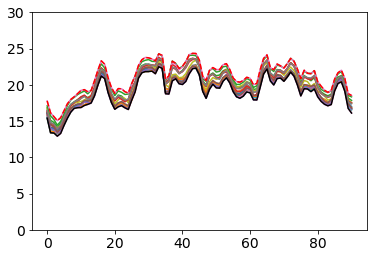

In [35]:
ens_min = [None] * (len(lake_dict)+1)
ens_max = [None] * (len(lake_dict)+1)
for rdx, run in enumerate(train_dict['T2']):
    tdx = (run[0] >= ts) & (run[0] < te)
    value_temp = run[1].isel(time=tdx).mean(dim=['south_north','west_east']).values
    
    plt.plot(value_temp)
    plt.ylim([0, 30])
    
    if rdx == 0:
        ens_min[-1] = value_temp
        ens_max[-1] = value_temp
    else:
        ens_min[-1] = minimum(value_temp,ens_min[-1])
        ens_max[-1] = maximum(value_temp,ens_max[-1])
        
    for ldx, lake in enumerate(lake_dict):  # need to work this out: node=lake_dict[lake]
        value_temp = run[1].isel(time=tdx).mean(dim=['south_north','west_east']).values
        if rdx == 0:
            ens_min[ldx] = value_temp
            ens_max[ldx] = value_temp
        else:
            ens_min[ldx] = minimum(value_temp,ens_min[ldx])
            ens_max[ldx] = maximum(value_temp,ens_max[ldx])

plt.plot(ens_min[-1],'k-')
plt.plot(ens_max[-1],'r--')

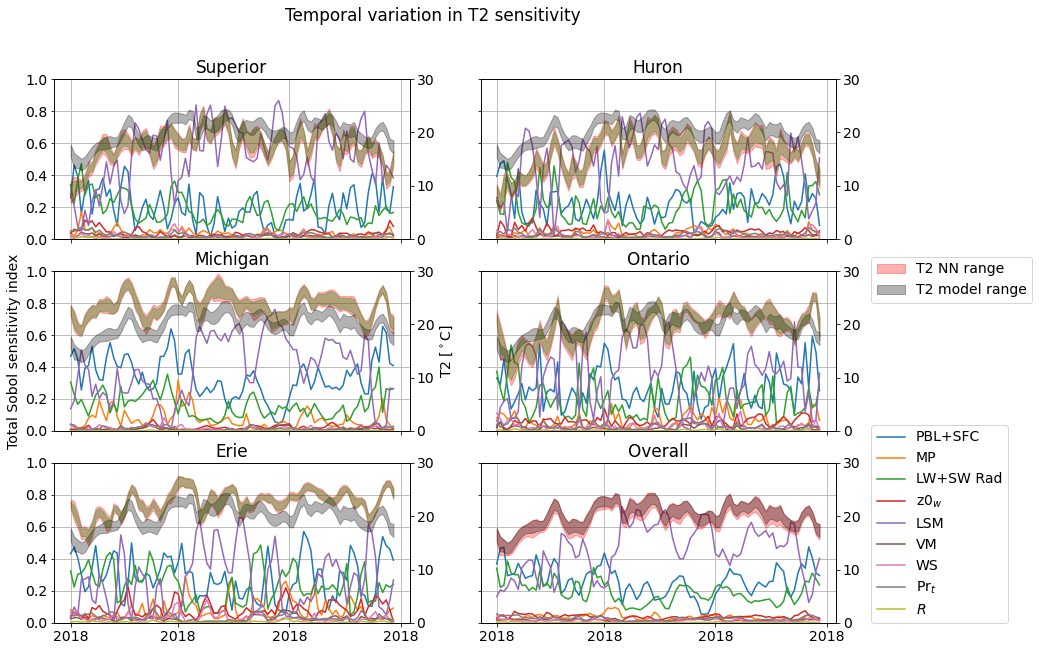

In [64]:
time = train_dict['T2'][0][0]
tdx = (time >= ts) & (time < te)
time = time[tdx]

fig, axs = plt.subplots(3, 2, sharey=True, sharex=True, figsize=(14,10))
for ldx, lake in enumerate(lake_dict):
    for pdx,pname in enumerate(pname_paper):
        axs.flat[ldx].plot(time,sens_sobol_lake[ldx]['total'][:,pdx],label=pname)

    axs.flat[ldx].set_title(f'{lake}')
    axs.flat[ldx].set_ylim([0,1.0])
    axs.flat[ldx].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    axs.flat[ldx].grid()
    
    ax2 = axs.flat[ldx].twinx()
    ax2.fill_between(time,nn_ens_min[ldx],nn_ens_max[ldx],color='r',alpha=0.3,label='T2 NN range')
    ax2.fill_between(time,ens_min[ldx],ens_max[ldx],color='k',alpha=0.3,label='T2 model range')
    ax2.fill_between(time,pc_ens_min[ldx],pc_ens_max[ldx],color='g',alpha=0.3,label='T2 PC range')
    ax2.set_ylim([0,30])
    
    if ldx == 2:
        axs.flat[ldx].set_ylabel('Total Sobol sensitivity index')
        ax2.set_ylabel('T2 [$^\circ$C]')
    
    axs.flat[ldx].set_xticks(axs.flat[ldx].get_xticks(), rotation=50)
for pdx,pname in enumerate(pname_paper):
    axs.flat[-1].plot(time,sens_sobol_lake[-1]['total'][:,pdx],label=pname)

axs.flat[-1].set_title('Overall')
axs.flat[-1].set_ylim([0,1.0])
axs.flat[ldx].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
axs.flat[-1].grid()
axs.flat[-1].legend(loc=(1.1,0))
    
ax2 = axs.flat[-1].twinx()
ax2.fill_between(time,nn_ens_min[-1],nn_ens_max[-1],color='r',alpha=0.3,label='T2 NN range')
ax2.fill_between(time,ens_min[-1],ens_max[-1],color='k',alpha=0.3,label='T2 model range')
#ax2.fill_between(time,pc_ens_min[-1],pc_ens_max[-1],color='g',alpha=0.3,label='T2 PC range')

ax2.set_ylim([0,30])

ax2.legend(loc=(1.1,2))
    
plt.suptitle('Temporal variation in T2 sensitivity')

plt.show()

In [ ]:
point_array = range(0,surrogate_model_x.shape[0],10)

In [ ]:
# get the sensitivity for the PC surrogate
sens_sobol_x = compute_sensitivities(surrogate_model_x[point_array], train_x, sample_size=10000)

In [ ]:
for pdx,pname in enumerate(pnames):
    fig = plt.figure(figsize=(12,6))
    plt.scatter(train_dict['LST'][0][1].lon[point_array],
             train_dict['LST'][0][1].lat[point_array],
             s=10,
             c=sens_sobol_x['total'][:,pdx],
             vmin=0,vmax=1.0)

    plt.title(f'{pname}')
    plt.colorbar(label='mean spatial sensitivity')
    plt.grid()
    plt.show()